# Introduction

Our business problem began by identifying the most common products bought together and for that we did several recommendation systems.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('orders.csv')
df.drop(columns="Unnamed: 0", axis =1, inplace=True)
df.head()

,client,delivery_place,date,product,product_description,measure,quantity,is_internal_client,warehouse_zone,product_type,product_subtype
0,1128254,6346669,2023-01-06,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,600.0,Não,AMB,Bebidas,Aguas Minerais
1,1001096,6001131,2023-01-03,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,120.0,Não,AMB,Bebidas,Aguas Minerais
2,1001096,6001131,2023-01-17,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,120.0,Não,AMB,Bebidas,Aguas Minerais
3,1121833,6358142,2023-01-04,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,12.0,Não,AMB,Bebidas,Aguas Minerais
4,1122758,6328488,2023-01-04,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,60.0,Não,AMB,Bebidas,Aguas Minerais


How the company works is that for every deivery place in a day a truck takes the products, there can be more than one delivery place per day, as well several clients can have the same delivery place

In [2]:
#Implementing a orders Id
order = df.groupby(['date','delivery_place']).size().reset_index()
order['order_n'] = [i+1 for i in range(len(order))]
order = order.drop(0,axis=1)
data=df.merge(order, on=['date','delivery_place'])
data.head()

,client,delivery_place,date,product,product_description,measure,quantity,is_internal_client,warehouse_zone,product_type,product_subtype,order_n
0,1128254,6346669,2023-01-06,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,600.0,Não,AMB,Bebidas,Aguas Minerais,3238
1,1128254,6346669,2023-01-06,558440,COCA COLA LATA 0.33,UN,1080.0,Não,AMB,Bebidas,Refrigerantes,3238
2,1128254,6346669,2023-01-06,202791,"COMPAL CLASSICO PESSEGO 0,20 GFA (15)",UN,900.0,Não,AMB,Bebidas,Sumos,3238
3,1128254,6346669,2023-01-06,202790,"COMPAL CLASSICO PERA 0,20 GFA (15)",UN,300.0,Não,AMB,Bebidas,Sumos,3238
4,1001096,6001131,2023-01-03,126898,AGUA DAS PEDRAS SALGADAS 6x0.33 PET,UN,120.0,Não,AMB,Bebidas,Aguas Minerais,627


## Recommendation system

## Apriori

### Association Rules

With the order id in place we can now start building a recommendation system based on what items are frequently purchased together. This can be useful for suggesting related items to customers, as well as informing product placement and marketing strategies.

To do this, we use the Apriori algorithm to identify frequent itemsets - that is, sets of items that appear together in a minimum number of orders. From these itemsets, we can generate association rules that tell us which items tend to be purchased together.

The Apriori algorithm is a scalable and efficient way to mine large datasets for frequent itemsets and generate association rules. By using this approach, we can identify patterns and relationships in transactional data that can inform our recommendation system and ultimately help us make data-driven decisions about product recommendations, marketing strategies, and product placement.

In [3]:
from mlxtend.frequent_patterns import apriori, association_rules
# Load data
df = data

# Filter for orders with more than one item
df = df.groupby('order_n').filter(lambda x: len(x) > 1)

# Pivot data to create binary matrix
basket = pd.pivot_table(df, index='order_n', columns='product_description', values='quantity', aggfunc='sum', fill_value=0)

# Convert values to binary
basket[basket > 0] = 1

# Find frequent itemsets
freq_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(freq_itemsets, metric='lift', min_threshold=1)

# Sort rules by lift and support
rules = rules.sort_values(['lift', 'support'], ascending=[False, False])

# Print top 5 rules
rules.head(5)


C:\Users\berna\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
918,"(TOMATE MEDIO, CENOURA, ARROZ LONGO COMUM AGUL...","(BATATA BRANCA, ALFACE)",0.071516,0.139700,0.054247,0.758530,5.429721,0.044256,3.562765,0.878667
935,"(BATATA BRANCA, ALFACE)","(TOMATE MEDIO, CENOURA, ARROZ LONGO COMUM AGUL...",0.139700,0.071516,0.054247,0.388310,5.429721,0.044256,1.517901,0.948307
917,"(CENOURA, ALFACE, ARROZ LONGO COMUM AGULHA EUR...","(TOMATE MEDIO, BATATA BRANCA)",0.085875,0.117879,0.054247,0.631694,5.358837,0.044124,2.395076,0.889804
936,"(TOMATE MEDIO, BATATA BRANCA)","(CENOURA, ALFACE, ARROZ LONGO COMUM AGULHA EUR...",0.117879,0.085875,0.054247,0.460191,5.358837,0.044124,1.693423,0.922087
947,"(COUVE LOMBARDO, CENOURA, ALFACE)","(TOMATE MEDIO, BATATA BRANCA)",0.097325,0.117879,0.060863,0.625362,5.305118,0.049391,2.354593,0.898998


In [4]:
rules[rules['confidence']>=0.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
918,"(TOMATE MEDIO, CENOURA, ARROZ LONGO COMUM AGUL...","(BATATA BRANCA, ALFACE)",0.071516,0.139700,0.054247,0.758530,5.429721,0.044256,3.562765,0.878667
953,"(COUVE LOMBARDO, BATATA BRANCA, ALFACE)","(TOMATE MEDIO, CENOURA)",0.079212,0.146176,0.060863,0.768365,5.256455,0.049285,3.686076,0.879418
851,"(ALFACE, PEPINO)","(TOMATE MEDIO, CENOURA)",0.078508,0.146176,0.059690,0.760311,5.201356,0.048214,3.562215,0.876559
951,"(COUVE LOMBARDO, CENOURA, TOMATE MEDIO)","(BATATA BRANCA, ALFACE)",0.083904,0.139700,0.060863,0.725391,5.192507,0.049142,3.132825,0.881365
597,"(CENOURA, ARROZ LONGO COMUM AGULHA EUROCHEFE 1...","(BATATA BRANCA, ALFACE)",0.092539,0.139700,0.066776,0.721602,5.165384,0.053849,3.090186,0.888637
...,...,...,...,...,...,...,...,...,...,...
45,(PERNA FRANGO N/CALIBRADA EXTRA CONG.),(ALFACE),0.096058,0.231300,0.077194,0.803615,3.474343,0.054976,3.914252,0.787856
129,(PERNA FRANGO N/CALIBRADA EXTRA CONG.),(CENOURA),0.096058,0.207367,0.068653,0.714704,3.446561,0.048734,2.778286,0.785289
10,(ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG),(ALFACE),0.139090,0.231300,0.108494,0.780027,3.372363,0.076322,3.494520,0.817126
48,(PURE DE BATATA EM FLOCOS LUTOSA 1 KG),(ALFACE),0.081746,0.231300,0.060582,0.741102,3.204075,0.041674,2.969126,0.749136


The output shows the top 5 association rules sorted by lift and support. These rules indicate which products tend to be purchased together, with a lift value indicating the degree of association between the antecedent and consequent products.

Looking at the top rule, we see that customers who buy "ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG", "TOMATE MEDIO", and "CEBOLA BRANCA NACIONAL KG" are likely to also buy "ALFACE" and "BATATA BRANCA". The high lift value of 5.43 indicates a strong association between the two sets of products.

Similarly, the other rules suggest that customers who buy certain sets of products are also likely to buy other specific products. For example, customers who buy "ALFACE", "BATATA BRANCA", and "TOMATE MEDIO" are likely to also buy "ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG".

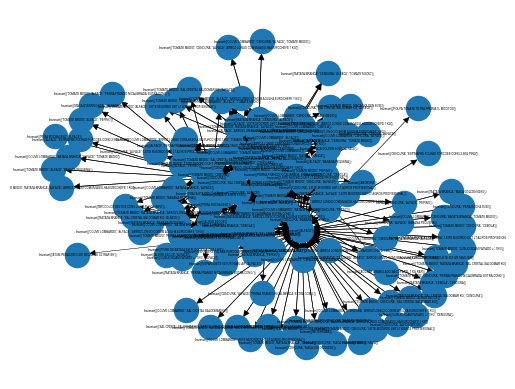

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create empty graph
G = nx.DiGraph()

# Add nodes for antecedents and consequents
for item in set(rules['antecedents']).union(set(rules['consequents'])):
    G.add_node(item)

# Add edges for rules
for _, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Set positions for nodes
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, width=[d['weight']*0.1 for (u, v, d) in G.edges(data=True)])

# Add labels for nodes
node_labels = {item: item for item in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=2, font_family='arial')

# Display graph
plt.axis('off')
plt.show()


In [6]:
# Group rules by antecedents
grouped_rules = rules.groupby('antecedents')

# Calculate the average lift for each set of antecedents
avg_lifts = grouped_rules.mean()['lift'].sort_values(ascending=False)

# Get the top 5 sets of antecedents by average lift
top_antecedents = avg_lifts.head(5).index

# Print the top 5 sets of antecedents and their corresponding consequents
for antecedent in top_antecedents:
    consequents = set(rules[rules['antecedents'] == antecedent]['consequents'])
    print('Antecedents: {}'.format(list(antecedent)))
    print('Consequents: {}'.format(list(consequents)))
    print('---')


Antecedents: ['TOMATE MEDIO', 'CENOURA', 'ALFACE', 'ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG']
Consequents: [frozenset({'BATATA BRANCA'})]
---
Antecedents: ['TOMATE MEDIO', 'CENOURA', 'ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG']
Consequents: [frozenset({'BATATA BRANCA'}), frozenset({'ALFACE'}), frozenset({'BATATA BRANCA', 'ALFACE'})]
---
Antecedents: ['CEBOLA', 'ALFACE']
Consequents: [frozenset({'BATATA BRANCA', 'CENOURA'}), frozenset({'CENOURA'}), frozenset({'TOMATE MEDIO', 'CENOURA'}), frozenset({'TOMATE MEDIO', 'BATATA BRANCA'}), frozenset({'BATATA BRANCA'}), frozenset({'TOMATE MEDIO'}), frozenset({'COUVE LOMBARDO'})]
---
Antecedents: ['CENOURA', 'ALFACE', 'ARROZ LONGO COMUM AGULHA EUROCHEFE 1 KG']
Consequents: [frozenset({'BATATA BRANCA'}), frozenset({'TOMATE MEDIO', 'BATATA BRANCA'}), frozenset({'TOMATE MEDIO'}), frozenset({'COUVE LOMBARDO'})]
---
Antecedents: ['CENOURA', 'ALFACE', 'PEPINO']
Consequents: [frozenset({'TOMATE MEDIO'})]
---


### K-Means

C:\Users\berna\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



3 is the best number of clusters according with the Elbow method.
8 is the best number of clusters according with the Silhouette method.


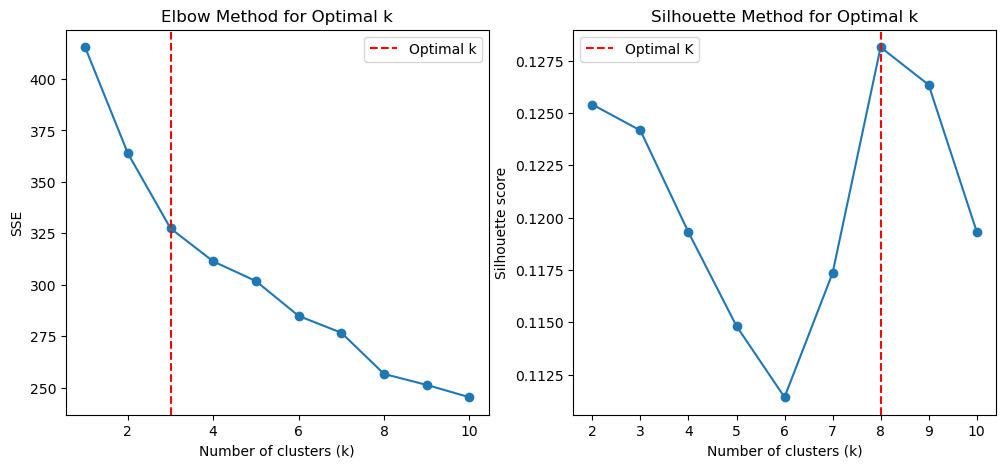

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# Filter for orders with more than one item
df = data.groupby('order_n').filter(lambda x: len(x) > 1)

# Pivot data to create binary matrix
basket = pd.pivot_table(df, index='order_n', columns='product_description', values='quantity', aggfunc='sum', fill_value=0)

# Convert values to binary
basket[basket > 0] = 1

# Find frequent itemsets
freq_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Convert frequent itemsets to transactions
transactions = freq_itemsets['itemsets'].apply(lambda x: list(x)).tolist()

# Convert transactions to one-hot encoded format
mlb = MultiLabelBinarizer()
transactions_encoded = mlb.fit_transform(transactions)

# Convert transactions to 2D numpy array
X = np.array(transactions_encoded)

# Set range for elbow method
range_n_clusters = range(1, 11)

# Create an empty list to store SSE values for each K
sse = []

# Fit KMeans algorithms for K = 1 to 10 and record SSE
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Plot the elbow
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].plot(range_n_clusters, sse, 'o-')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('SSE')
axs[0].set_title('Elbow Method for Optimal k')

# Find the best number of clusters using the elbow method
kl = KneeLocator(range_n_clusters, sse, curve='convex', direction='decreasing')
best_k = kl.elbow
axs[0].axvline(x=best_k, linestyle='--', color='r', label='Optimal k')
axs[0].legend()

# Set range for silhouette score
range_n_clusters_silhouette = range(2, 11)

# Create an empty list to store silhouette scores for each K
silhouette_scores = []

# Fit KMeans algorithms for K = 2 to 10 and record silhouette score
for k in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot the silhouette score
axs[1].plot(range_n_clusters_silhouette, silhouette_scores, 'o-')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette Method for Optimal k')

# Find the best number of clusters using the silhouette score
best_k_silhouette = range_n_clusters_silhouette[np.argmax(silhouette_scores)]
axs[1].axvline(x=best_k_silhouette, linestyle='--', color='r', label='Optimal K')
axs[1].legend()

print(f"\n{best_k} is the best number of clusters according with the Elbow method.\n{best_k_silhouette} is the best number of clusters according with the Silhouette method.")



The Elbow method suggests that 3 is the best number of clusters, while the Silhouette method suggests that 8 is the best number of clusters. This discrepancy could be due to the fact that these two methods evaluate different aspects of the clustering results. The Elbow method is based on minimizing the within-cluster sum of squares, which can result in a low WCSS for a larger number of clusters even if the clusters are not well-defined. On the other hand, the Silhouette method focuses on how well each data point fits within its assigned cluster and therefore may be better at identifying more nuanced clusters that may not be captured by the WCSS. Ultimately, the choice of the optimal number of clusters should be based on a combination of both methods and also on domain knowledge and interpretation of the clustering results.

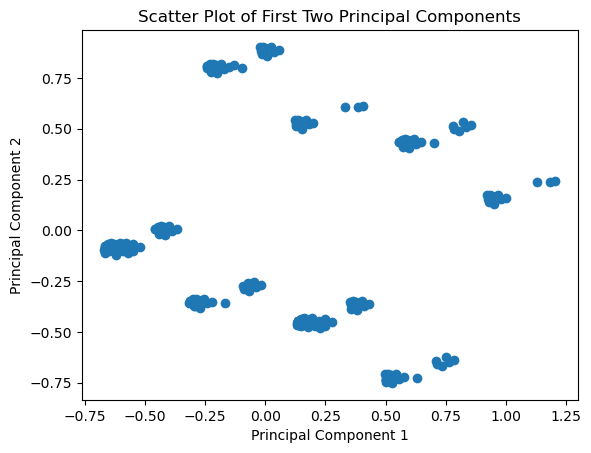

In [8]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Fit PCA to the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')
plt.show()

#### Using the best number of clusters frm the elbow method

In [9]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
clusters = kmeans.predict(X)

# Add cluster labels to frequent itemsets dataframe
freq_itemsets['cluster'] = clusters

# Print frequent itemsets with cluster labels
print(freq_itemsets)

      support                                           itemsets  cluster
0    0.062928                                          (ABOBORA)        2
1    0.135336             (ACUCAR GRANULADO SACO PAPEL 1 KG RAR)        2
2    0.058423                    (AGUA SPRING PORTUGAL 1,5L PET)        2
3    0.231300                                           (ALFACE)        0
4    0.072407                                      (ALHOS SECOS)        2
..        ...                                                ...      ...
223  0.060113  (TOMATE MEDIO, CENOURA, SAL CRISTAL SALDOMAR K...        1
224  0.056218  (TOMATE MEDIO, BATATA BRANCA, CENOURA, ARROZ L...        1
225  0.063069  (COUVE LOMBARDO, BATATA BRANCA, CENOURA, TOMAT...        1
226  0.054247  (CENOURA, ARROZ LONGO COMUM AGULHA EUROCHEFE 1...        1
227  0.060863  (CENOURA, ALFACE, COUVE LOMBARDO, BATATA BRANC...        1

[228 rows x 3 columns]


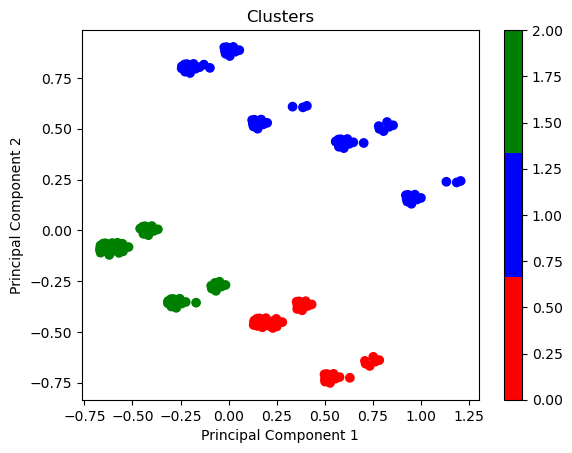

In [10]:
# Define a discrete colormap with a different color for each cluster
cmap = ListedColormap(['red', 'blue', 'green'])

# Plot the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters')
plt.colorbar()
plt.show()

#### Using the best number of clusters frm the silhouette method

In [11]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=best_k_silhouette, random_state=0).fit(X)
clusters = kmeans.predict(X)

# Add cluster labels to frequent itemsets dataframe
freq_itemsets['cluster'] = clusters

# Print frequent itemsets with cluster labels
print(freq_itemsets)

      support                                           itemsets  cluster
0    0.062928                                          (ABOBORA)        1
1    0.135336             (ACUCAR GRANULADO SACO PAPEL 1 KG RAR)        1
2    0.058423                    (AGUA SPRING PORTUGAL 1,5L PET)        1
3    0.231300                                           (ALFACE)        7
4    0.072407                                      (ALHOS SECOS)        1
..        ...                                                ...      ...
223  0.060113  (TOMATE MEDIO, CENOURA, SAL CRISTAL SALDOMAR K...        0
224  0.056218  (TOMATE MEDIO, BATATA BRANCA, CENOURA, ARROZ L...        5
225  0.063069  (COUVE LOMBARDO, BATATA BRANCA, CENOURA, TOMAT...        5
226  0.054247  (CENOURA, ARROZ LONGO COMUM AGULHA EUROCHEFE 1...        2
227  0.060863  (CENOURA, ALFACE, COUVE LOMBARDO, BATATA BRANC...        2

[228 rows x 3 columns]


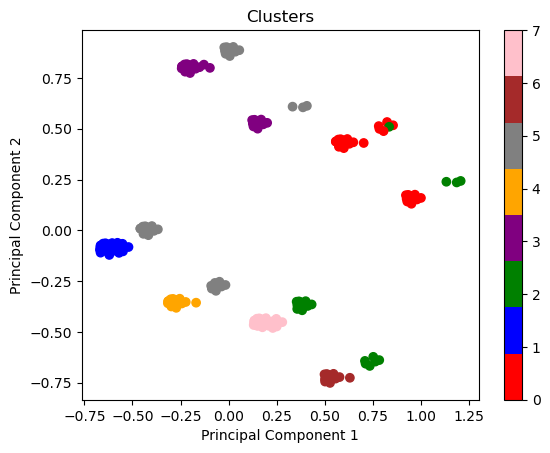

In [12]:
# Define a discrete colormap with a different color for each cluster
cmap = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'gray', 'brown', 'pink'])

# Plot the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters')
plt.colorbar()
plt.show()

The Silhouette method gives out too dispersed clusters making it unreliable for the data at hand, therefore we decided the best number of clusters to use will be 3, the nuber of optimal cluster given by the elbow method